# Prophet Model:

- <a href = "#desc"> Model Description </a>
- <a href = "#imp">Model Implementation </a>

<span id = "desc"></span>
## Model Description: 

The main idea behind fb Prophet model is that it deccompose each component of the time series and make a seperated model for each component:

`Y(t) = g(t) + S(t) + h(t) + wt`

Where:
g(t)  ==> Trend Model.
S(t)  ==> Seasonality model.
h(t)  ==> holidays effect model.
wt    ==> Error term. 


### Trend Model: 

The trend of the overall time series represents the mean change of the magnitude of the time series, but in prophet model we can use this trand as on of two models:

1. <b>Saturating (Logistic):</b>

We can choose this model if our carryig capacity can be saturated or the trend is expected to stop growing at some point, as they say in the paper that describe the model the number of facebook active users compared to the oer all capacity of the people that have internet access.
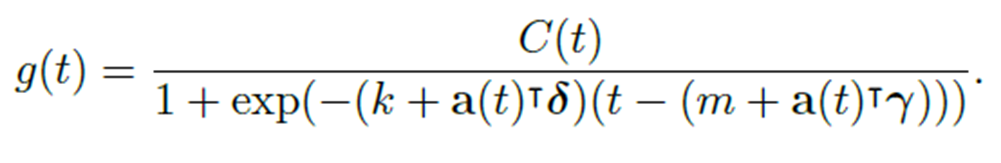

Where: 
- C(t) ==> Carrying capacity at that time
- k ==> Growth rate
- a(t) ==> is a vector that contains 1s and 0s to represent which change point to take into considaeration, where the model - can take the effect of the change points if the current time is behind the changepoint's time.
- Gamma ==> The numerial value that represents the effect of the a change point
- m ==> offset of the logestic regression function

<hr></hr>

2. <b>Linear:</b>

This model is choosed if the previuos case not applicable, and the trend is free to increas or decrease and don't have to be saturated at some point.
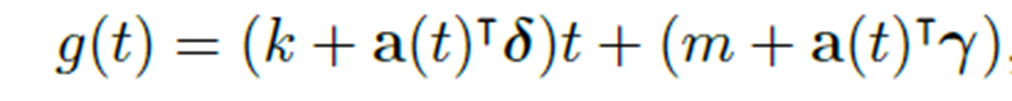

<b>Concept of changepoints:</b>

Change points is the points at which the trend is allowed to change, between two consequative change points the trend value will not be changed.

<img src="Picture1.png" style = "width:500px; height:300px;">

### Seasonality Model:

Fourier Series model is used to fit the seasonality of the time series analysis, this because the seasonality model is a periodic signal just like the behaviuor of the fourier series.

<img src="Picture2.png" style = "width:500px; height:100px;">

where: 
N ==> is the number of fourier series componenents.
P ==> is the period of seasonality(Month, Year, Day)

### Holidays Effect Model :

Here oe of the edges of prophet model that it deals with holidays effect by quantifying the effect that a certain holiday can cause to the signal
<img src="Picture4.png" style = "width:200px; height:40px;">

Where:
- K is the effect of the holiday and is considered to be normally distributed with mean of 0
- And Z{t) is a vector that contains 1s and 0s where 1s represents the time of the holidays to make the effect.

<img src="Picture3.png" style = "width:400px; height:60px;">

<span id="imp"></span>
## Model Implementation:

In [1]:
import pandas as pd
import numpy as np
import prophet as pt
import datetime as dt
import os
import matplotlib.pyplot as plt
%matplotlib inline
from prophet.plot import add_changepoints_to_plot
import time

### Preprocessing:

In [16]:
df = pd.read_csv('anomaly_imputed.csv', parse_dates = ["time"])

In [17]:
#checking for NaNs
df = df.drop(columns = ["anomaly", "week_day", "hour", "minute"])
df.isna().sum()

In [18]:
df

,time,grid_square,internet_cdr
0,2013-11-01 00:00:00,5056,517.607260
1,2013-11-01 00:10:00,5056,314.551305
2,2013-11-01 00:20:00,5056,341.527327
3,2013-11-01 00:30:00,5056,450.012415
4,2013-11-01 00:40:00,5056,312.166782
...,...,...,...
64795,2013-12-20 23:10:00,5258,925.535544
64796,2013-12-20 23:20:00,5258,769.307634
64797,2013-12-20 23:30:00,5258,769.111522
64798,2013-12-20 23:40:00,5258,741.301673


In [19]:
df.reset_index()
df = df.rename(columns = {"indernet_cdr": "internet_cdr"})
df = df.groupby("grid_square")

#### Getting supprters:
to help model to calculate effects of several factors to produce accurate calculations.

In [20]:
def get_hour(datetime_o):
    """
    this function to get the hour of the day to use it as an additional regressor
    """
    return datetime_o.hour
def get_day(datetime_o):
    """
    this function to get the the day to use it as an additional regressor
    """
    return datetime_o.day
def get_weekday(datetime_o):
    """
    this function to get the the day of the week to use it as an additional regressor
    """
    return datetime_o.weekday()

def active_time(t):
    """
    function to determine if the hour is an active hour or not
    """
    if(t in range(7, 14)):
        return 1
    else:
        return 0
def is_christmas(t):
    """
    function to determine if the hour is an active hour or not
    """
    if(t in [25,26]):
        return 1
    else:
        return 0   
    
def is_weekends(t):
    """
    Function to determine if this day is a weekend or not
    """
    if(t in ["Saturday", "Sunday"]):
        return 1
    else:
        return 0

In [21]:
"""
Defining MIlan Holiday to porvide prophet model with:
"""
milan_holidays = pd.DataFrame({
    "holiday": "milan",
    "ds"     : pd.to_datetime([
        "2013-11-01", "2013-12-07", 
        "2013-12-08", "2013-12-25", 
        "2013-12-26", "2013-12-31"]), 
    'lower_window': 0, 
    'upper_window': 1
    }
)

In [51]:
def init_prophet():
    """
    A  function to initialize the prophet model with best parameters
    and added some custome seasonalities
    """
    #inititating the model
    model = pt.Prophet(changepoint_range=0.9, changepoint_prior_scale=0.005,
                       n_changepoints = 50, weekly_seasonality= 100,
                       daily_seasonality= 100,
                       seasonality_mode = "additive",
                       holidays  = milan_holidays)
    # Adding country holidays
    model.add_country_holidays(country_name= "IT")
    # Custom regressors for times in day accoding to active time
    model.add_regressor("hour")
    model.add_regressor("day")
    model.add_regressor("dayofweek")
    return model

#### Preparing the data before the modelling:

In [52]:
def divide_data(iter_num, data):
    """
    function to divide the data set into training and prediction sets fo each iteration
    """
    t_periods = {"month": 144*30} #Training period: 1Month
    p_periods = {1: 144,2: 2*144, 3:3*144, 7: 144*7} # Prediction periods (1,2,3 and 7 days)
    
    # For training set
    train_period = t_periods["month"]
    start_t = 144*iter_num # Starting point of the training data
    end_t = start_t + train_period # End of the training data
    X_train = data.iloc[start_t:end_t, :] #Getting Training Data Frame
    
    # For prediction set
    predict_1 = p_periods[1] # 1 Day prediction period
    predict_2 = p_periods[2] # 2 Days prediction period
    predict_3 = p_periods[3] # 3 Days prediction period
    predict_7 = p_periods[7] # 7 Days prediction period
    
    start_p = end_t # Defining the starting point of prediction to be the ed of training 
    end_p1 = start_p + predict_1 # Calculating the end point of prediction for 1 Day 
    end_p2 = start_p + predict_2 # Calculating the end point of prediction for 2 Days
    end_p3 = start_p + predict_3 # Calculating the end point of prediction for 3 Days
    end_p7 = start_p + predict_7 # Calculating the end point of prediction for 7 Days
    
    """
    Getting the training dataset to provide to the model, 
    have to contain all columns that the model need as a regressor and also the other wanted columns
    """
    X_predict_1 = data.iloc[start_p:end_p1, [0,2,3,4]] 
    X_predict_2 = data.iloc[start_p:end_p2, [0,2,3,4]]
    X_predict_3 = data.iloc[start_p:end_p3, [0,2,3,4]]
    X_predict_7 = data.iloc[start_p:end_p7, [0,2,3,4]]
    
    """
    Getting only predictions to provide to predict method
    """
    full_predict1 = data.iloc[start_p:end_p1, 0:2]
    full_predict2 = data.iloc[start_p:end_p2, 0:2]
    full_predict3 = data.iloc[start_p:end_p3, 0:2]
    full_predict7 = data.iloc[start_p:end_p7, 0:2]
    
    return [X_train, X_predict_7, full_predict7]

In [53]:
def fit_predict(model, train, predict):
    """
    Function to train and predict form a model
    """
    # fitting the model
    model.fit(train)
    #making forecsting for the future 7-days
    forcast = model.predict(predict)
    return forcast

#### Getting the right shape of prediction data frame after prediction:

In [54]:
def prediction_dataframe(data, forcast_p, grid_num):
    """
    this function is just to aggregate the predictions with the original
    data in the same dataframe to be able to store it and use it leter
    """
    # initiating the dataframe
    df_p = pd.DataFrame(columns = ["y","yhat","error", "ds", "grid"])
    #get the original data
    df_p["y"] = data["y"]
    ### resetting the index to allign the mesurments
    df_p.index = np.arange(df_p.shape[0])
    # get the frocasted values
    df_p["yhat"] = forcast_p["yhat"]
    # error for predictions
    df_p["error"] = df_p["y"] - df_p["yhat"]
    #add the grid number
    if len(grid_num) != len(forcast_p):
        df_p["grid"] = grid_num[:len(forcast_p)]
        
    else: 
        df_p["grid"] = grid_num
    #reseting the index again
    forcast_p["ds"].index = np.arange(df_p.shape[0])
    #adding the time to the dataframe
    df_p["ds"] = forcast_p["ds"]
    return(df_p)

#### Defining Metrics:

In [55]:
def nrmse(df_p):
    """
    function to calculate the normalized root mean sqaure error
    """
    return np.sqrt((df_p["error"]**2).sum() / df_p.shape[0])/df_p["y"].mean()
def mape(df_p):
    """
    function to provide the mean absolute percentage error
    """
    return np.absolute(df_p["error"] / df_p["y"]).sum()/ df_p.shape[0]

# Modelling and Forecasting:


In [56]:
# Get the list of the grids in the city
grids = list(df.groups.keys())

"""
Itializing DataFrame of the errors to save the errors is an proper way
"""
# error dataframe multiindexing
arrays = [
    ["1 day","1 day","grid", "2 days", "2 days","grid",  "3 days", "3 days","grid",  "7 days", "7 days","grid" ] ,
    ["NRMSE", "MAPE","grid",  "NRMSE", "MAPE","grid",  "NRMSE", "MAPE","grid",  "NRMSE", "MAPE","grid"],
]
# Error data frame columns index
errors = list(zip(*arrays))
#day_errors_dataframe
error_idex_d = pd.MultiIndex.from_tuples(errors[:3], names=["period", "metric"])
error_d = pd.DataFrame(columns = error_idex_d)
#2days Error dataframe
error_idex_2d = pd.MultiIndex.from_tuples(errors[3:6], names=["period", "metric"])
error_2d = pd.DataFrame(columns =error_idex_2d)
#3days Error dataframe
error_idex_3d = pd.MultiIndex.from_tuples(errors[6:9], names=["period", "metric"])
error_3d = pd.DataFrame(columns = error_idex_3d)
#week_errors_dataframe
error_idex_w = pd.MultiIndex.from_tuples(errors[9:], names=["period", "metric"])
error_w = pd.DataFrame(columns = error_idex_w)

# Making a day and a week predictions dataframes to store the values, predictions
# corresponding to each time steps
predictions = pd.DataFrame(columns = ["y","yhat","error", "ds", "grid" ])

In [57]:
grids

[5056, 5057, 5058, 5156, 5157, 5158, 5256, 5257, 5258]

### Start the modelling process:

In [58]:
start_time_all = time.time()
for grid in grids:
    start_grid = time.time()
    #Get the group of the grid num
    df_g = df.get_group(grid)[["time", "internet_cdr"]]
    df_g.index = np.arange(df_g.shape[0])
    #converting time to datetime object
    df_g["time"] = pd.to_datetime(df_g["time"])
    #convert the columns to the names of prophet standards
    df_g = df_g.rename(columns = {"time": "ds", "internet_cdr": "y"})
    #creatig a new col for the hour
    df_g["hour"] = df_g["ds"].apply(get_hour)
    df_g["day"] = df_g["ds"].apply(get_day)
    df_g["dayofweek"] = df_g["ds"].apply(get_weekday)
    for i in range(20):
        start_forecast = time.time()
        # Day predictions
        #data division
        d_data  = divide_data(i, df_g)
        X_train = d_data[0]
        future_day7 = d_data[1]
        full_predict7 = d_data[2]
        #multiply to get the column size
        grid_num = [grid]*1008
        #initializing the model
        model = init_prophet()
        #predicting the next day
        forcast = fit_predict(model, X_train, future_day7)
        #get the dataframe of the prediction and the original measuments
        d_prediction = prediction_dataframe(full_predict7,
                                            forcast, grid_num)
        # concatinatio the full dataframe of prediction
        predictions = pd.concat([predictions, d_prediction], ignore_index= True)
        #calculating the nrmse
        nrmse_d = nrmse(d_prediction.iloc[:144,:])
        nrmse_2d = nrmse(d_prediction.iloc[:2*144,:])
        nrmse_3d = nrmse(d_prediction.iloc[:3*144,:])
        nrmse_7d = nrmse(d_prediction.iloc[:7*144,:])
        #calculating the mape
        mape_d = mape(d_prediction.iloc[:144,:])
        mape_2d = mape(d_prediction.iloc[:2*144,:])
        mape_3d = mape(d_prediction.iloc[:3*144,:])
        mape_7d = mape(d_prediction.iloc[:7*144,:])

        error_1d = pd.DataFrame([[nrmse_d,mape_d, grid]],columns = error_idex_d)
        error_2d2 = pd.DataFrame([[nrmse_2d,mape_2d, grid]],columns = error_idex_2d)
        error_3d3 = pd.DataFrame([[nrmse_3d,mape_3d, grid]],columns = error_idex_3d)
        error_7d7 = pd.DataFrame([[nrmse_7d,mape_7d, grid]],columns = error_idex_w)
        #adding to the error datframe
        error_d = pd.concat([error_d, error_1d])
        error_2d = pd.concat([error_2d, error_2d2])
        error_3d = pd.concat([error_3d, error_3d3])
        error_w = pd.concat([error_w, error_7d7])
        end_forecast = time.time()
        iter_time = (end_forecast - start_forecast)/60
        print(f"========== {i} iteration took {iter_time} minutes ======")
        print(error_d.shape, error_2d.shape, error_3d.shape, error_w.shape)
        print("========== forcasting {} for grid {} is done =========".format( i+1,grid))
    end_grid = time.time()
    grid_time = (end_grid - start_grid)/60
    print(f"========== {grid} training and prediction took {grid_time} minutes. ===========")
end_time_all = time.time()
alltime = (end_time_all - start_time_all)/60
print(f"========= All predictions took {alltime} minutes ===========")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 0 iteration took 0.24250927368799846 minutes ======
(1, 3) (1, 3) (1, 3) (1, 3)
========== forcasting 1 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 1 iteration took 0.26923735936482746 minutes ======
(2, 3) (2, 3) (2, 3) (2, 3)
========== forcasting 2 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 2 iteration took 0.22124327023824056 minutes ======
(3, 3) (3, 3) (3, 3) (3, 3)
========== forcasting 3 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 3 iteration took 0.1574934442838033 minutes ======
(4, 3) (4, 3) (4, 3) (4, 3)
========== forcasting 4 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 4 iteration took 0.16131671667098998 minutes ======
(5, 3) (5, 3) (5, 3) (5, 3)
========== forcasting 5 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 5 iteration took 0.2234957496325175 minutes ======
(6, 3) (6, 3) (6, 3) (6, 3)
========== forcasting 6 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 6 iteration took 0.19045735994974772 minutes ======
(7, 3) (7, 3) (7, 3) (7, 3)
========== forcasting 7 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 7 iteration took 0.2468526244163513 minutes ======
(8, 3) (8, 3) (8, 3) (8, 3)
========== forcasting 8 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 8 iteration took 0.3107694784800212 minutes ======
(9, 3) (9, 3) (9, 3) (9, 3)
========== forcasting 9 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 9 iteration took 0.19892212152481079 minutes ======
(10, 3) (10, 3) (10, 3) (10, 3)
========== forcasting 10 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 10 iteration took 0.4900207042694092 minutes ======
(11, 3) (11, 3) (11, 3) (11, 3)
========== forcasting 11 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 11 iteration took 0.3448041796684265 minutes ======
(12, 3) (12, 3) (12, 3) (12, 3)
========== forcasting 12 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 12 iteration took 0.4680066784222921 minutes ======
(13, 3) (13, 3) (13, 3) (13, 3)
========== forcasting 13 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 13 iteration took 0.34756269454956057 minutes ======
(14, 3) (14, 3) (14, 3) (14, 3)
========== forcasting 14 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 14 iteration took 0.19492435852686565 minutes ======
(15, 3) (15, 3) (15, 3) (15, 3)
========== forcasting 15 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 15 iteration took 0.18257317145665486 minutes ======
(16, 3) (16, 3) (16, 3) (16, 3)
========== forcasting 16 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 16 iteration took 0.28708242972691855 minutes ======
(17, 3) (17, 3) (17, 3) (17, 3)
========== forcasting 17 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 17 iteration took 0.26031832297643026 minutes ======
(18, 3) (18, 3) (18, 3) (18, 3)
========== forcasting 18 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 18 iteration took 0.5098457137743632 minutes ======
(19, 3) (19, 3) (19, 3) (19, 3)
========== forcasting 19 for grid 5056 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 19 iteration took 0.25957454442977906 minutes ======
(20, 3) (20, 3) (20, 3) (20, 3)
========== forcasting 20 for grid 5056 is done =========
========== 5056 training and prediction took 5.5700814604759215 minutes. ===========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 0 iteration took 0.2087690830230713 minutes ======
(21, 3) (21, 3) (21, 3) (21, 3)
========== forcasting 1 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 1 iteration took 0.26194873253504436 minutes ======
(22, 3) (22, 3) (22, 3) (22, 3)
========== forcasting 2 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 2 iteration took 0.24636930227279663 minutes ======
(23, 3) (23, 3) (23, 3) (23, 3)
========== forcasting 3 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 3 iteration took 0.23442853689193727 minutes ======
(24, 3) (24, 3) (24, 3) (24, 3)
========== forcasting 4 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 4 iteration took 0.3128807822863261 minutes ======
(25, 3) (25, 3) (25, 3) (25, 3)
========== forcasting 5 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 5 iteration took 0.21107151110967 minutes ======
(26, 3) (26, 3) (26, 3) (26, 3)
========== forcasting 6 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 6 iteration took 0.19923648834228516 minutes ======
(27, 3) (27, 3) (27, 3) (27, 3)
========== forcasting 7 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 7 iteration took 0.3633259137471517 minutes ======
(28, 3) (28, 3) (28, 3) (28, 3)
========== forcasting 8 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 8 iteration took 0.21493222316106161 minutes ======
(29, 3) (29, 3) (29, 3) (29, 3)
========== forcasting 9 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 9 iteration took 0.1703156073888143 minutes ======
(30, 3) (30, 3) (30, 3) (30, 3)
========== forcasting 10 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 10 iteration took 0.3601467172304789 minutes ======
(31, 3) (31, 3) (31, 3) (31, 3)
========== forcasting 11 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 11 iteration took 0.3107107996940613 minutes ======
(32, 3) (32, 3) (32, 3) (32, 3)
========== forcasting 12 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 12 iteration took 0.2534419973691305 minutes ======
(33, 3) (33, 3) (33, 3) (33, 3)
========== forcasting 13 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 13 iteration took 0.19716062943140666 minutes ======
(34, 3) (34, 3) (34, 3) (34, 3)
========== forcasting 14 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 14 iteration took 0.42880455652872723 minutes ======
(35, 3) (35, 3) (35, 3) (35, 3)
========== forcasting 15 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 15 iteration took 0.3227733055750529 minutes ======
(36, 3) (36, 3) (36, 3) (36, 3)
========== forcasting 16 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 16 iteration took 0.24509955247243245 minutes ======
(37, 3) (37, 3) (37, 3) (37, 3)
========== forcasting 17 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 17 iteration took 0.22052302360534667 minutes ======
(38, 3) (38, 3) (38, 3) (38, 3)
========== forcasting 18 for grid 5057 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 18 iteration took 0.3233209729194641 minutes ======
(39, 3) (39, 3) (39, 3) (39, 3)
========== forcasting 19 for grid 5057 is done =========
========== 19 iteration took 0.3638652284940084 minutes ======
(40, 3) (40, 3) (40, 3) (40, 3)
========== forcasting 20 for grid 5057 is done =========
========== 5057 training and prediction took 5.450996641318003 minutes. ===========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 0 iteration took 0.23890859285990398 minutes ======
(41, 3) (41, 3) (41, 3) (41, 3)
========== forcasting 1 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 1 iteration took 0.2882819533348083 minutes ======
(42, 3) (42, 3) (42, 3) (42, 3)
========== forcasting 2 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 2 iteration took 0.2643793821334839 minutes ======
(43, 3) (43, 3) (43, 3) (43, 3)
========== forcasting 3 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 3 iteration took 0.31036540667215984 minutes ======
(44, 3) (44, 3) (44, 3) (44, 3)
========== forcasting 4 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 4 iteration took 0.20628291368484497 minutes ======
(45, 3) (45, 3) (45, 3) (45, 3)
========== forcasting 5 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 5 iteration took 0.2524212241172791 minutes ======
(46, 3) (46, 3) (46, 3) (46, 3)
========== forcasting 6 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 6 iteration took 0.2567759434382121 minutes ======
(47, 3) (47, 3) (47, 3) (47, 3)
========== forcasting 7 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 7 iteration took 0.17467050552368163 minutes ======
(48, 3) (48, 3) (48, 3) (48, 3)
========== forcasting 8 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 8 iteration took 0.2556678851445516 minutes ======
(49, 3) (49, 3) (49, 3) (49, 3)
========== forcasting 9 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 9 iteration took 0.2856653253237406 minutes ======
(50, 3) (50, 3) (50, 3) (50, 3)
========== forcasting 10 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 10 iteration took 0.23952566385269164 minutes ======
(51, 3) (51, 3) (51, 3) (51, 3)
========== forcasting 11 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 11 iteration took 0.24261311292648316 minutes ======
(52, 3) (52, 3) (52, 3) (52, 3)
========== forcasting 12 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 12 iteration took 0.274271825949351 minutes ======
(53, 3) (53, 3) (53, 3) (53, 3)
========== forcasting 13 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 13 iteration took 0.2603107452392578 minutes ======
(54, 3) (54, 3) (54, 3) (54, 3)
========== forcasting 14 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 14 iteration took 0.42732555866241456 minutes ======
(55, 3) (55, 3) (55, 3) (55, 3)
========== forcasting 15 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 15 iteration took 0.4055730899175008 minutes ======
(56, 3) (56, 3) (56, 3) (56, 3)
========== forcasting 16 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 16 iteration took 0.2528246601422628 minutes ======
(57, 3) (57, 3) (57, 3) (57, 3)
========== forcasting 17 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 17 iteration took 0.2294644276301066 minutes ======
(58, 3) (58, 3) (58, 3) (58, 3)
========== forcasting 18 for grid 5058 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 18 iteration took 0.32316389083862307 minutes ======
(59, 3) (59, 3) (59, 3) (59, 3)
========== forcasting 19 for grid 5058 is done =========
========== 19 iteration took 0.6060984810193379 minutes ======
(60, 3) (60, 3) (60, 3) (60, 3)
========== forcasting 20 for grid 5058 is done =========
========== 5058 training and prediction took 5.797473259766897 minutes. ===========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 0 iteration took 0.20489534934361775 minutes ======
(61, 3) (61, 3) (61, 3) (61, 3)
========== forcasting 1 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 1 iteration took 0.2181430459022522 minutes ======
(62, 3) (62, 3) (62, 3) (62, 3)
========== forcasting 2 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 2 iteration took 0.23430010477701824 minutes ======
(63, 3) (63, 3) (63, 3) (63, 3)
========== forcasting 3 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 3 iteration took 0.3363197922706604 minutes ======
(64, 3) (64, 3) (64, 3) (64, 3)
========== forcasting 4 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 4 iteration took 0.21723464330037434 minutes ======
(65, 3) (65, 3) (65, 3) (65, 3)
========== forcasting 5 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 5 iteration took 0.20577034155527751 minutes ======
(66, 3) (66, 3) (66, 3) (66, 3)
========== forcasting 6 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 6 iteration took 0.3072709560394287 minutes ======
(67, 3) (67, 3) (67, 3) (67, 3)
========== forcasting 7 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 7 iteration took 0.21525941292444864 minutes ======
(68, 3) (68, 3) (68, 3) (68, 3)
========== forcasting 8 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 8 iteration took 0.3563573280970255 minutes ======
(69, 3) (69, 3) (69, 3) (69, 3)
========== forcasting 9 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 9 iteration took 0.26070966323216754 minutes ======
(70, 3) (70, 3) (70, 3) (70, 3)
========== forcasting 10 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 10 iteration took 0.2236860950787862 minutes ======
(71, 3) (71, 3) (71, 3) (71, 3)
========== forcasting 11 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 11 iteration took 0.23696828683217366 minutes ======
(72, 3) (72, 3) (72, 3) (72, 3)
========== forcasting 12 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 12 iteration took 0.20382943948109944 minutes ======
(73, 3) (73, 3) (73, 3) (73, 3)
========== forcasting 13 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 13 iteration took 0.17436979214350382 minutes ======
(74, 3) (74, 3) (74, 3) (74, 3)
========== forcasting 14 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 14 iteration took 0.2048826853434245 minutes ======
(75, 3) (75, 3) (75, 3) (75, 3)
========== forcasting 15 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 15 iteration took 0.23384839693705242 minutes ======
(76, 3) (76, 3) (76, 3) (76, 3)
========== forcasting 16 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 16 iteration took 0.16471507946650188 minutes ======
(77, 3) (77, 3) (77, 3) (77, 3)
========== forcasting 17 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 17 iteration took 0.24883451064427695 minutes ======
(78, 3) (78, 3) (78, 3) (78, 3)
========== forcasting 18 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 18 iteration took 0.2207978089650472 minutes ======
(79, 3) (79, 3) (79, 3) (79, 3)
========== forcasting 19 for grid 5156 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 19 iteration took 0.1931255062421163 minutes ======
(80, 3) (80, 3) (80, 3) (80, 3)
========== forcasting 20 for grid 5156 is done =========
========== 5156 training and prediction took 4.664183108011882 minutes. ===========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 0 iteration took 0.3566702405611674 minutes ======
(81, 3) (81, 3) (81, 3) (81, 3)
========== forcasting 1 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 1 iteration took 0.19840359687805176 minutes ======
(82, 3) (82, 3) (82, 3) (82, 3)
========== forcasting 2 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 2 iteration took 0.3305125077565511 minutes ======
(83, 3) (83, 3) (83, 3) (83, 3)
========== forcasting 3 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 3 iteration took 0.6488687674204509 minutes ======
(84, 3) (84, 3) (84, 3) (84, 3)
========== forcasting 4 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 4 iteration took 0.30529702504475914 minutes ======
(85, 3) (85, 3) (85, 3) (85, 3)
========== forcasting 5 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 5 iteration took 0.27754596471786497 minutes ======
(86, 3) (86, 3) (86, 3) (86, 3)
========== forcasting 6 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 6 iteration took 0.22665012280146282 minutes ======
(87, 3) (87, 3) (87, 3) (87, 3)
========== forcasting 7 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 7 iteration took 0.26309213240941365 minutes ======
(88, 3) (88, 3) (88, 3) (88, 3)
========== forcasting 8 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 8 iteration took 0.25212679704030355 minutes ======
(89, 3) (89, 3) (89, 3) (89, 3)
========== forcasting 9 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 9 iteration took 0.3236784338951111 minutes ======
(90, 3) (90, 3) (90, 3) (90, 3)
========== forcasting 10 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 10 iteration took 0.26296200752258303 minutes ======
(91, 3) (91, 3) (91, 3) (91, 3)
========== forcasting 11 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 11 iteration took 0.3834327260653178 minutes ======
(92, 3) (92, 3) (92, 3) (92, 3)
========== forcasting 12 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 12 iteration took 0.20055854717890423 minutes ======
(93, 3) (93, 3) (93, 3) (93, 3)
========== forcasting 13 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 13 iteration took 0.22563296159108479 minutes ======
(94, 3) (94, 3) (94, 3) (94, 3)
========== forcasting 14 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 14 iteration took 0.5788048903147379 minutes ======
(95, 3) (95, 3) (95, 3) (95, 3)
========== forcasting 15 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 15 iteration took 0.3509124596913656 minutes ======
(96, 3) (96, 3) (96, 3) (96, 3)
========== forcasting 16 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 16 iteration took 0.27980694770812986 minutes ======
(97, 3) (97, 3) (97, 3) (97, 3)
========== forcasting 17 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 17 iteration took 0.7628462751706441 minutes ======
(98, 3) (98, 3) (98, 3) (98, 3)
========== forcasting 18 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 18 iteration took 0.21384273767471312 minutes ======
(99, 3) (99, 3) (99, 3) (99, 3)
========== forcasting 19 for grid 5157 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 19 iteration took 0.48227816025416054 minutes ======
(100, 3) (100, 3) (100, 3) (100, 3)
========== forcasting 20 for grid 5157 is done =========
========== 5157 training and prediction took 6.92652686436971 minutes. ===========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 0 iteration took 0.2027476191520691 minutes ======
(101, 3) (101, 3) (101, 3) (101, 3)
========== forcasting 1 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 1 iteration took 0.24793262481689454 minutes ======
(102, 3) (102, 3) (102, 3) (102, 3)
========== forcasting 2 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 2 iteration took 0.18655869960784913 minutes ======
(103, 3) (103, 3) (103, 3) (103, 3)
========== forcasting 3 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 3 iteration took 0.3330723762512207 minutes ======
(104, 3) (104, 3) (104, 3) (104, 3)
========== forcasting 4 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 4 iteration took 0.38549495935440065 minutes ======
(105, 3) (105, 3) (105, 3) (105, 3)
========== forcasting 5 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 5 iteration took 0.2803079843521118 minutes ======
(106, 3) (106, 3) (106, 3) (106, 3)
========== forcasting 6 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 6 iteration took 0.24635123014450072 minutes ======
(107, 3) (107, 3) (107, 3) (107, 3)
========== forcasting 7 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 7 iteration took 0.22497625748316447 minutes ======
(108, 3) (108, 3) (108, 3) (108, 3)
========== forcasting 8 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 8 iteration took 0.3271316329638163 minutes ======
(109, 3) (109, 3) (109, 3) (109, 3)
========== forcasting 9 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 9 iteration took 0.278173557917277 minutes ======
(110, 3) (110, 3) (110, 3) (110, 3)
========== forcasting 10 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 10 iteration took 0.3817897399266561 minutes ======
(111, 3) (111, 3) (111, 3) (111, 3)
========== forcasting 11 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 11 iteration took 0.3176417946815491 minutes ======
(112, 3) (112, 3) (112, 3) (112, 3)
========== forcasting 12 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 12 iteration took 0.25143346389134724 minutes ======
(113, 3) (113, 3) (113, 3) (113, 3)
========== forcasting 13 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 13 iteration took 0.2488862991333008 minutes ======
(114, 3) (114, 3) (114, 3) (114, 3)
========== forcasting 14 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 14 iteration took 0.23642731507619222 minutes ======
(115, 3) (115, 3) (115, 3) (115, 3)
========== forcasting 15 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 15 iteration took 0.28840990861256915 minutes ======
(116, 3) (116, 3) (116, 3) (116, 3)
========== forcasting 16 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 16 iteration took 0.32035257418950397 minutes ======
(117, 3) (117, 3) (117, 3) (117, 3)
========== forcasting 17 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 17 iteration took 0.2711416522661845 minutes ======
(118, 3) (118, 3) (118, 3) (118, 3)
========== forcasting 18 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 18 iteration took 0.24142378568649292 minutes ======
(119, 3) (119, 3) (119, 3) (119, 3)
========== forcasting 19 for grid 5158 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 19 iteration took 0.27288291056950886 minutes ======
(120, 3) (120, 3) (120, 3) (120, 3)
========== forcasting 20 for grid 5158 is done =========
========== 5158 training and prediction took 5.5453671058019 minutes. ===========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 0 iteration took 0.34975326458613076 minutes ======
(121, 3) (121, 3) (121, 3) (121, 3)
========== forcasting 1 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 1 iteration took 0.19868393341700236 minutes ======
(122, 3) (122, 3) (122, 3) (122, 3)
========== forcasting 2 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 2 iteration took 0.17552764415740968 minutes ======
(123, 3) (123, 3) (123, 3) (123, 3)
========== forcasting 3 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 3 iteration took 0.31824904680252075 minutes ======
(124, 3) (124, 3) (124, 3) (124, 3)
========== forcasting 4 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 4 iteration took 0.20707417726516725 minutes ======
(125, 3) (125, 3) (125, 3) (125, 3)
========== forcasting 5 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 5 iteration took 0.3271621028582255 minutes ======
(126, 3) (126, 3) (126, 3) (126, 3)
========== forcasting 6 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 6 iteration took 0.2845708807309469 minutes ======
(127, 3) (127, 3) (127, 3) (127, 3)
========== forcasting 7 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 7 iteration took 0.25941874980926516 minutes ======
(128, 3) (128, 3) (128, 3) (128, 3)
========== forcasting 8 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 8 iteration took 0.36049153010050455 minutes ======
(129, 3) (129, 3) (129, 3) (129, 3)
========== forcasting 9 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 9 iteration took 0.27519080638885496 minutes ======
(130, 3) (130, 3) (130, 3) (130, 3)
========== forcasting 10 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 10 iteration took 0.2551370024681091 minutes ======
(131, 3) (131, 3) (131, 3) (131, 3)
========== forcasting 11 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 11 iteration took 0.3601701021194458 minutes ======
(132, 3) (132, 3) (132, 3) (132, 3)
========== forcasting 12 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 12 iteration took 0.30235830545425413 minutes ======
(133, 3) (133, 3) (133, 3) (133, 3)
========== forcasting 13 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 13 iteration took 0.4339453379313151 minutes ======
(134, 3) (134, 3) (134, 3) (134, 3)
========== forcasting 14 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 14 iteration took 0.5637928287188212 minutes ======
(135, 3) (135, 3) (135, 3) (135, 3)
========== forcasting 15 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 15 iteration took 0.29488927920659386 minutes ======
(136, 3) (136, 3) (136, 3) (136, 3)
========== forcasting 16 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 16 iteration took 0.3507265567779541 minutes ======
(137, 3) (137, 3) (137, 3) (137, 3)
========== forcasting 17 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 17 iteration took 0.19892698129018146 minutes ======
(138, 3) (138, 3) (138, 3) (138, 3)
========== forcasting 18 for grid 5256 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 18 iteration took 0.2672272761662801 minutes ======
(139, 3) (139, 3) (139, 3) (139, 3)
========== forcasting 19 for grid 5256 is done =========
========== 19 iteration took 0.23219172954559325 minutes ======
(140, 3) (140, 3) (140, 3) (140, 3)
========== forcasting 20 for grid 5256 is done =========
========== 5256 training and prediction took 6.017343819141388 minutes. ===========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 0 iteration took 0.30393703778584796 minutes ======
(141, 3) (141, 3) (141, 3) (141, 3)
========== forcasting 1 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 1 iteration took 0.22464609146118164 minutes ======
(142, 3) (142, 3) (142, 3) (142, 3)
========== forcasting 2 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 2 iteration took 0.3299857020378113 minutes ======
(143, 3) (143, 3) (143, 3) (143, 3)
========== forcasting 3 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 3 iteration took 0.29392695824305215 minutes ======
(144, 3) (144, 3) (144, 3) (144, 3)
========== forcasting 4 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 4 iteration took 0.275579837958018 minutes ======
(145, 3) (145, 3) (145, 3) (145, 3)
========== forcasting 5 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 5 iteration took 0.24976523319880167 minutes ======
(146, 3) (146, 3) (146, 3) (146, 3)
========== forcasting 6 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 6 iteration took 0.16903751691182453 minutes ======
(147, 3) (147, 3) (147, 3) (147, 3)
========== forcasting 7 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 7 iteration took 0.3819112300872803 minutes ======
(148, 3) (148, 3) (148, 3) (148, 3)
========== forcasting 8 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 8 iteration took 0.31296846866607664 minutes ======
(149, 3) (149, 3) (149, 3) (149, 3)
========== forcasting 9 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 9 iteration took 0.3297131935755412 minutes ======
(150, 3) (150, 3) (150, 3) (150, 3)
========== forcasting 10 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 10 iteration took 0.4984266479810079 minutes ======
(151, 3) (151, 3) (151, 3) (151, 3)
========== forcasting 11 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 11 iteration took 0.16193600098292033 minutes ======
(152, 3) (152, 3) (152, 3) (152, 3)
========== forcasting 12 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 12 iteration took 0.17436423699061077 minutes ======
(153, 3) (153, 3) (153, 3) (153, 3)
========== forcasting 13 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 13 iteration took 0.23665425777435303 minutes ======
(154, 3) (154, 3) (154, 3) (154, 3)
========== forcasting 14 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 14 iteration took 0.23818728526433308 minutes ======
(155, 3) (155, 3) (155, 3) (155, 3)
========== forcasting 15 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 15 iteration took 0.20966566403706868 minutes ======
(156, 3) (156, 3) (156, 3) (156, 3)
========== forcasting 16 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 16 iteration took 0.36454498767852783 minutes ======
(157, 3) (157, 3) (157, 3) (157, 3)
========== forcasting 17 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 17 iteration took 0.210552442073822 minutes ======
(158, 3) (158, 3) (158, 3) (158, 3)
========== forcasting 18 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 18 iteration took 0.36619459788004555 minutes ======
(159, 3) (159, 3) (159, 3) (159, 3)
========== forcasting 19 for grid 5257 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 19 iteration took 0.21461119254430136 minutes ======
(160, 3) (160, 3) (160, 3) (160, 3)
========== forcasting 20 for grid 5257 is done =========
========== 5257 training and prediction took 5.549847324689229 minutes. ===========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 0 iteration took 0.1484175403912862 minutes ======
(161, 3) (161, 3) (161, 3) (161, 3)
========== forcasting 1 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 1 iteration took 0.3310675104459127 minutes ======
(162, 3) (162, 3) (162, 3) (162, 3)
========== forcasting 2 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 2 iteration took 0.311176065603892 minutes ======
(163, 3) (163, 3) (163, 3) (163, 3)
========== forcasting 3 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 3 iteration took 0.21337599754333497 minutes ======
(164, 3) (164, 3) (164, 3) (164, 3)
========== forcasting 4 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 4 iteration took 0.21508864561716715 minutes ======
(165, 3) (165, 3) (165, 3) (165, 3)
========== forcasting 5 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 5 iteration took 0.15705625613530477 minutes ======
(166, 3) (166, 3) (166, 3) (166, 3)
========== forcasting 6 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 6 iteration took 0.1541170080502828 minutes ======
(167, 3) (167, 3) (167, 3) (167, 3)
========== forcasting 7 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 7 iteration took 0.29563920895258583 minutes ======
(168, 3) (168, 3) (168, 3) (168, 3)
========== forcasting 8 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 8 iteration took 0.22895505428314208 minutes ======
(169, 3) (169, 3) (169, 3) (169, 3)
========== forcasting 9 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 9 iteration took 0.28263335625330605 minutes ======
(170, 3) (170, 3) (170, 3) (170, 3)
========== forcasting 10 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 10 iteration took 0.2931155522664388 minutes ======
(171, 3) (171, 3) (171, 3) (171, 3)
========== forcasting 11 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 11 iteration took 0.28729594151178994 minutes ======
(172, 3) (172, 3) (172, 3) (172, 3)
========== forcasting 12 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 12 iteration took 0.2590007662773132 minutes ======
(173, 3) (173, 3) (173, 3) (173, 3)
========== forcasting 13 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 13 iteration took 0.36561194658279417 minutes ======
(174, 3) (174, 3) (174, 3) (174, 3)
========== forcasting 14 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 14 iteration took 0.4296286582946777 minutes ======
(175, 3) (175, 3) (175, 3) (175, 3)
========== forcasting 15 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 15 iteration took 0.3335086703300476 minutes ======
(176, 3) (176, 3) (176, 3) (176, 3)
========== forcasting 16 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 16 iteration took 0.2762950897216797 minutes ======
(177, 3) (177, 3) (177, 3) (177, 3)
========== forcasting 17 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 17 iteration took 0.4747518022855123 minutes ======
(178, 3) (178, 3) (178, 3) (178, 3)
========== forcasting 18 for grid 5258 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== 18 iteration took 0.2741190314292908 minutes ======
(179, 3) (179, 3) (179, 3) (179, 3)
========== forcasting 19 for grid 5258 is done =========
========== 19 iteration took 0.43822073539098105 minutes ======
(180, 3) (180, 3) (180, 3) (180, 3)
========== forcasting 20 for grid 5258 is done =========
========== 5258 training and prediction took 5.771190826098124 minutes. ===========
========= All predictions took 51.293026967843375 minutes ===========


### Exploring  predictions and error data frame:

In [59]:
print(predictions.shape)
print(predictions.head())

(154224, 5)
            y        yhat       error                  ds  grid
0  319.134853  123.478135  195.656718 2013-12-01 00:00:00  5056
1  350.216371  107.569855  242.646516 2013-12-01 00:10:00  5056
2  421.582783   88.179380  333.403403 2013-12-01 00:20:00  5056
3  333.801245   93.420839  240.380406 2013-12-01 00:30:00  5056
4  261.873589   76.262385  185.611204 2013-12-01 00:40:00  5056


In [60]:
predictions.sort_values(["ds", "grid"])

,y,yhat,error,ds,grid
0,319.134853,123.478135,195.656718,2013-12-01 00:00:00,5056
17136,308.087067,295.230813,12.856255,2013-12-01 00:00:00,5057
34272,695.919774,1117.300505,-421.380731,2013-12-01 00:00:00,5058
51408,357.671291,411.034216,-53.362925,2013-12-01 00:00:00,5156
68544,470.693315,436.915765,33.777550,2013-12-01 00:00:00,5157
...,...,...,...,...,...
152783,679.834414,934.290629,-254.456214,2013-12-20 23:50:00,5258
153359,679.834414,989.106808,-309.272394,2013-12-20 23:50:00,5258
153791,679.834414,949.712945,-269.878531,2013-12-20 23:50:00,5258
154079,679.834414,853.740653,-173.906238,2013-12-20 23:50:00,5258


In [61]:
error_2d

period    2 days            grid
metric     NRMSE      MAPE  grid
0       0.452839  0.649544  5056
0       0.103799  0.103300  5056
0       0.108036  0.091716  5056
0       0.098458  0.079113  5056
0       0.093119  0.077634  5056
..           ...       ...   ...
0       0.157906  0.142398  5258
0       0.139326  0.162078  5258
0       0.168789  0.194312  5258
0       0.118083  0.166891  5258
0       0.069133  0.097308  5258

[180 rows x 3 columns]

In [62]:
grids

[5056, 5057, 5058, 5156, 5157, 5158, 5256, 5257, 5258]

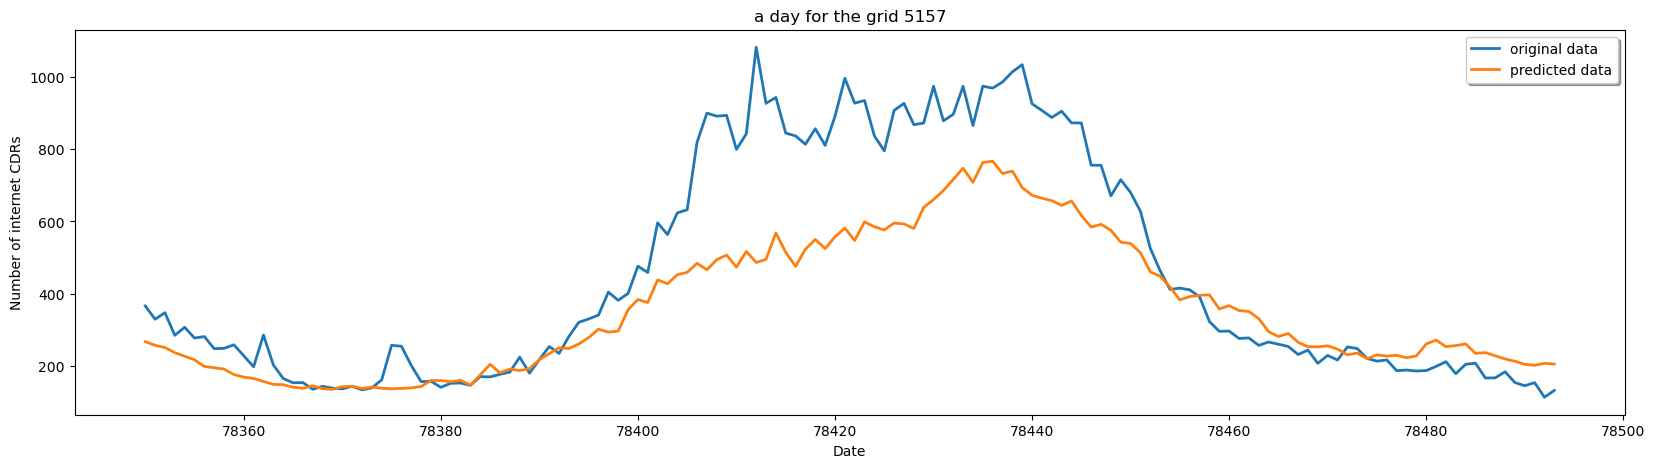

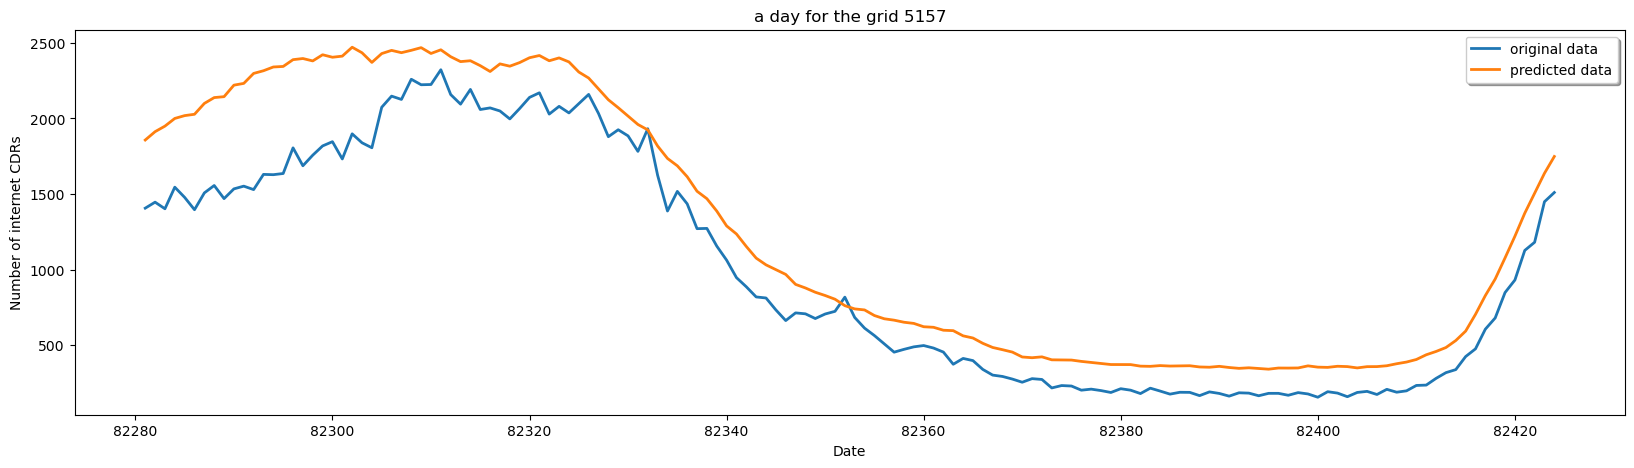

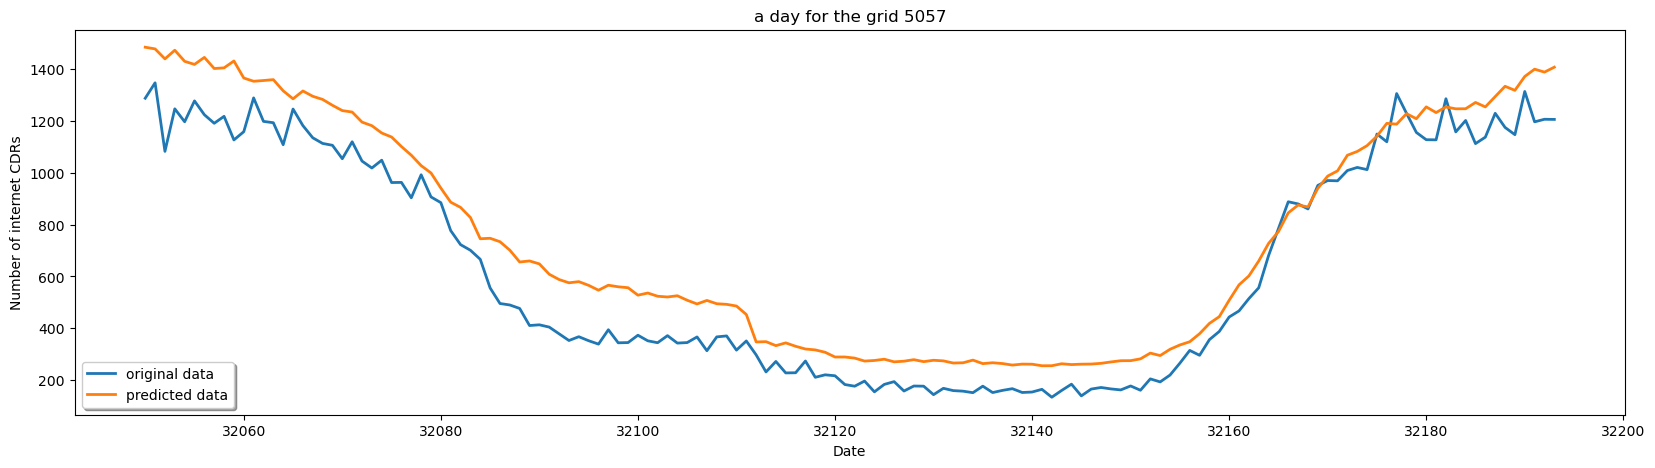

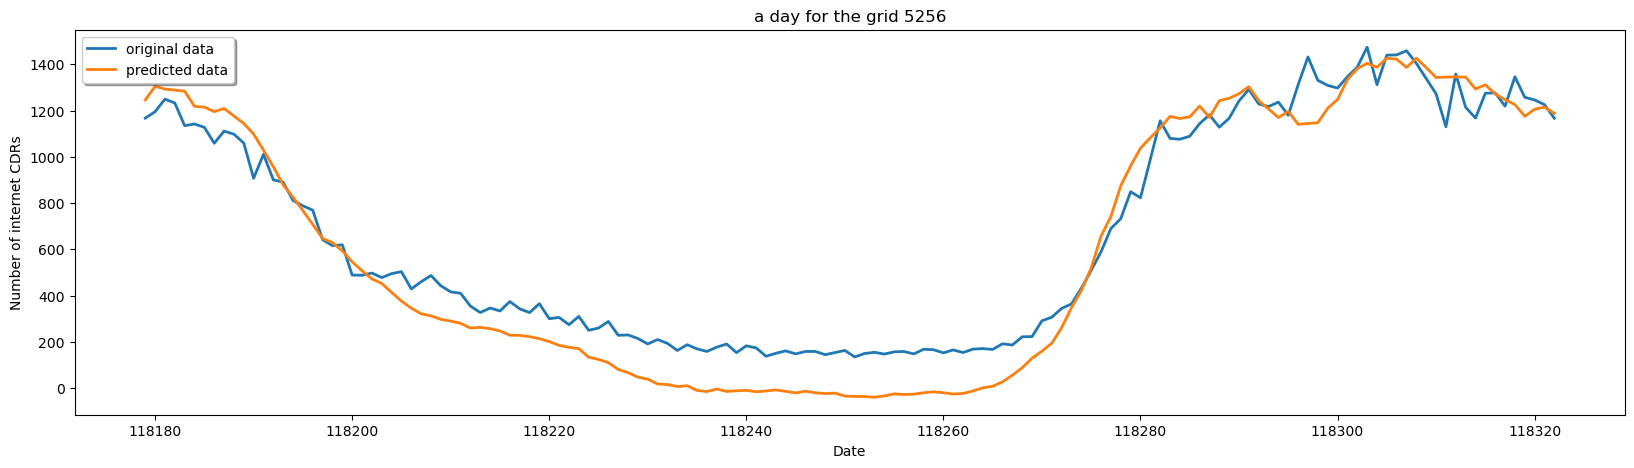

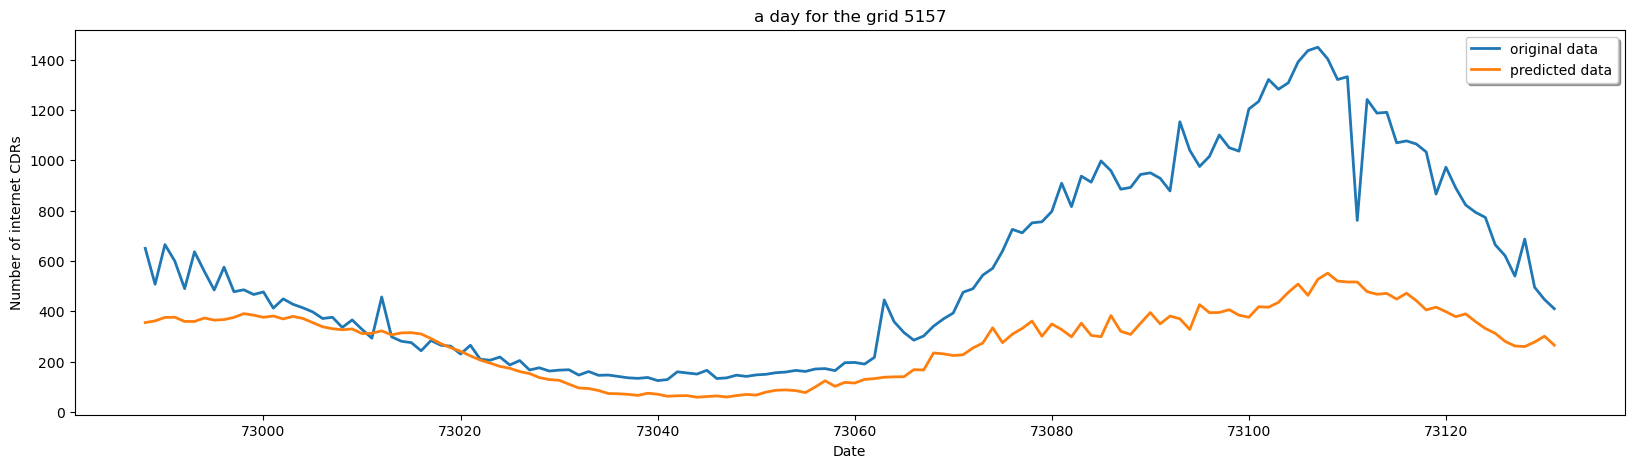

In [71]:
grid_days = predictions.groupby("grid")[["y","yhat","error", "ds"]]
grids = list(grid_days.groups.keys())
get_random_grids = np.random.choice(grids, size = 5)

for grid in get_random_grids:
    grid_df = grid_days.get_group(grid)
    n_rows = grid_df.shape[0]
    random_day_start = np.random.randint(0, n_rows, size = 1)
    get_random_day = grid_df[random_day_start[0]:random_day_start[0]+144]
    #plot the days and predictions
    fig, ax = plt.subplots(figsize = (20,5))
    ax.set_title('a day for the grid {}'.format(grid))
    line1, = ax.plot(get_random_day["y"], lw=2, label='original data')
    line2, = ax.plot(get_random_day["yhat"], lw=2, label='predicted data')
    leg = ax.legend(fancybox=True, shadow=True)
    ax.set_xlabel("Date")
    ax.set_ylabel("Number of internet CDRs")
    plt.show()


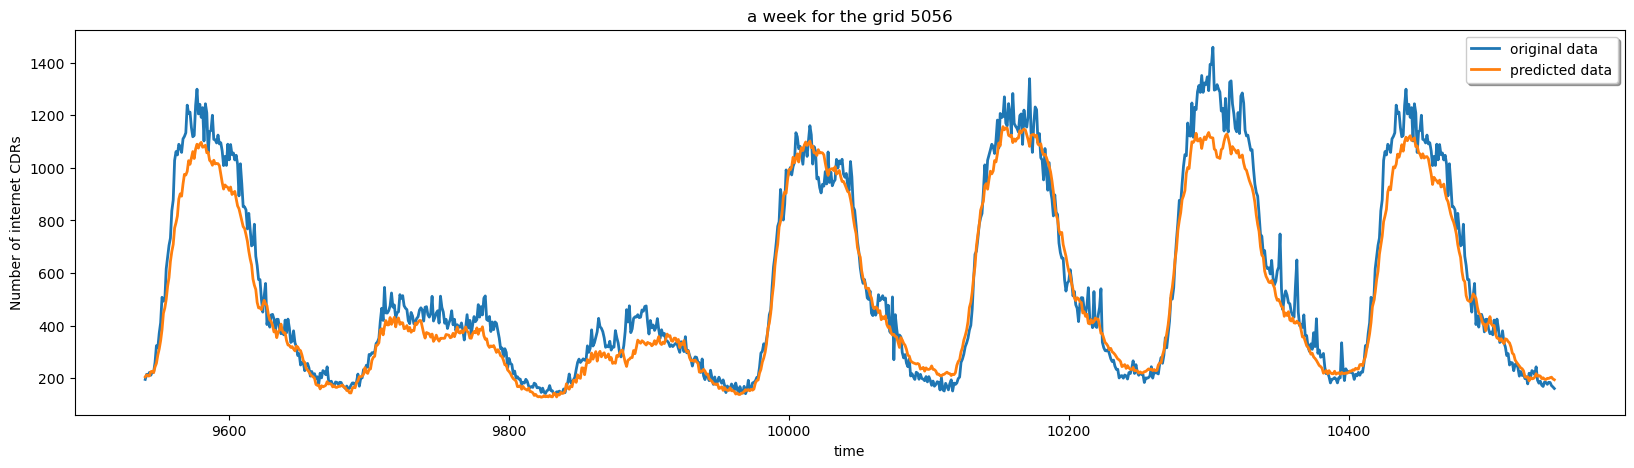

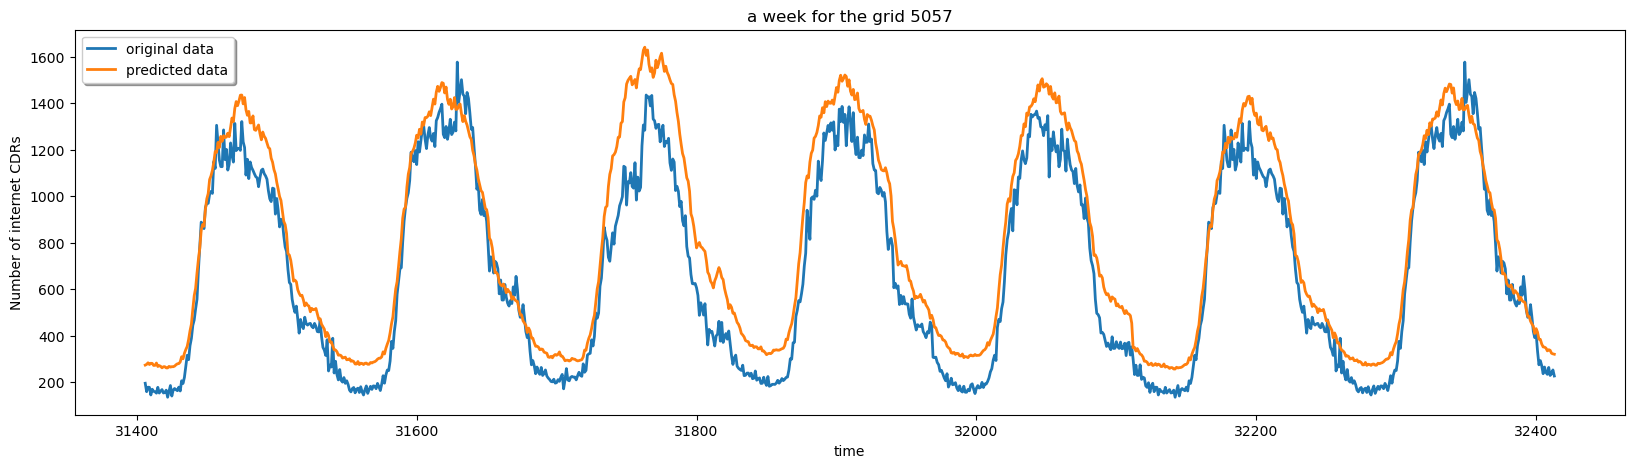

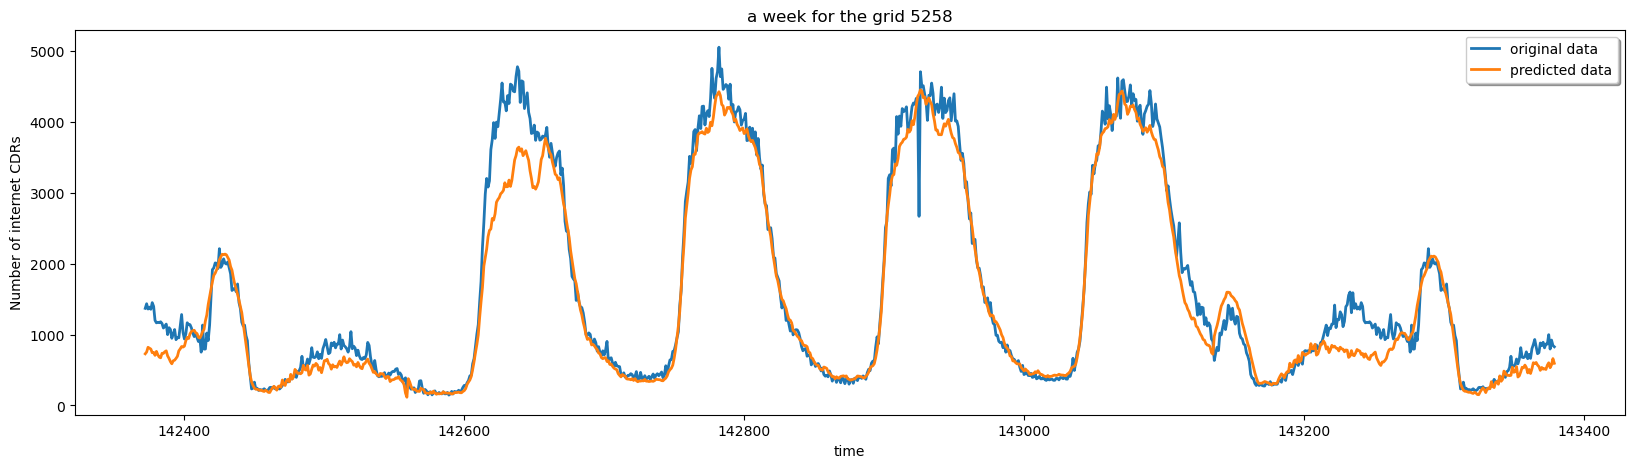

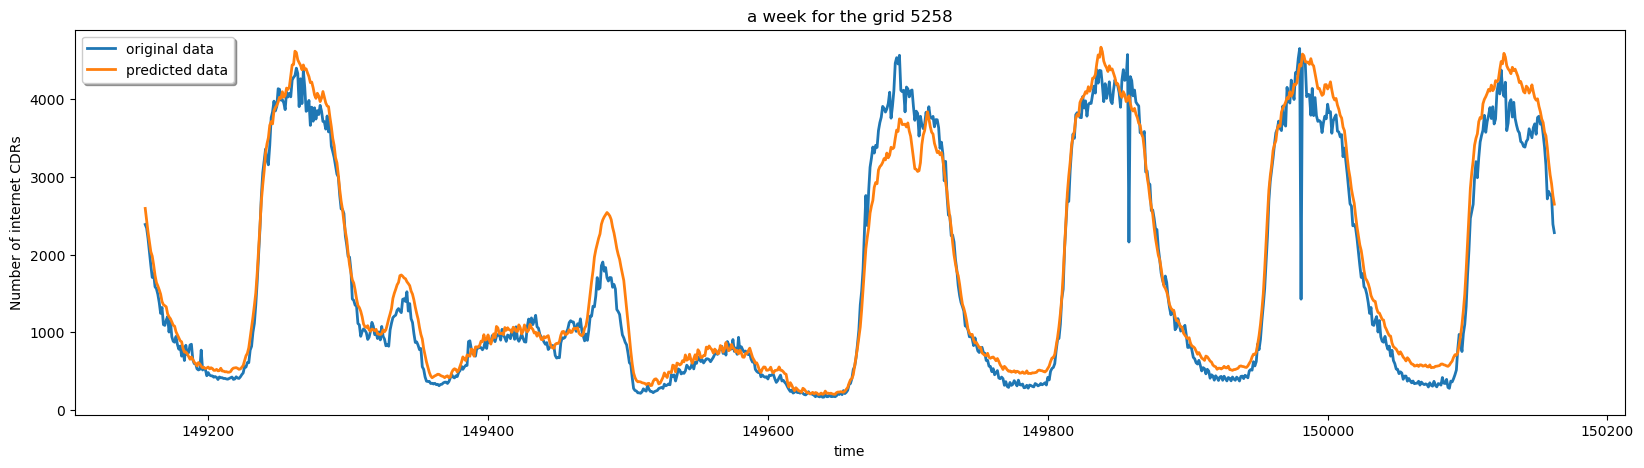

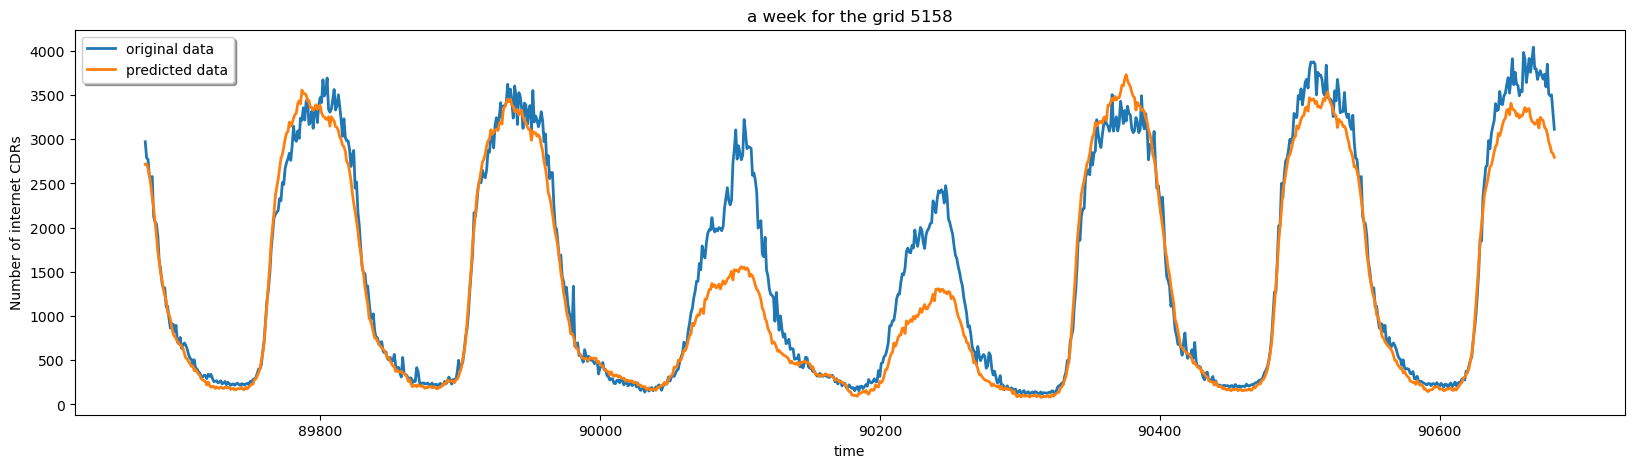

In [64]:
grids = list(grid_days.groups.keys())
get_random_grids = np.random.choice(grids, size = 5)

for grid in get_random_grids:
    grid_df = grid_days.get_group(grid)
    n_rows = grid_df.shape[0]
    random_day_start = np.random.randint(0, n_rows, size = 1)
    get_random_day = grid_df[random_day_start[0]:random_day_start[0]+1008]
    #plot week predictions
    fig, ax = plt.subplots(figsize = (20,5))
    ax.set_title('a week for the grid {}'.format(grid))
    line1, = ax.plot(get_random_day["y"], lw=2, label='original data')
    line2, = ax.plot(get_random_day["yhat"], lw=2, label='predicted data')
    leg = ax.legend(fancybox=True, shadow=True)
    ax.set_xlabel("time")
    ax.set_ylabel("Number of internet CDRs")
    plt.show()


### Saving the predictions to CSV Files:

In [67]:
predictions.to_csv("prophet_predictions_50.csv", index= False)

In [65]:
error_d.to_csv("error_day50.csv", index = False)
error_2d.to_csv("error_2day50.csv", index = False)
error_3d.to_csv("error_3day50.csv", index = False)
error_w.to_csv("error_week50.csv", index = False)

In [66]:
error_d.shape

(180, 3)